In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import corner

## Load and split the dataset 

In [2]:
data = pd.read_csv('Alignment-1-Learning.csv')

In [3]:
data.head()

mH1         mH2         mH3         mA1         mA2         mC1  \
0  125.0  389.681890  266.205554  357.716926  216.548541  437.974724   
1  125.0  466.478864  389.569317  402.965051  380.172764  364.184617   
2  125.0  220.948750  486.689377  537.099375  320.173513  243.467599   
3  125.0  328.343580  323.472676  221.752325  348.389320  487.707855   
4  125.0  335.247929  211.280269  206.867278  340.005918  207.546645   

          mC2  TanBeta1  TanBeta2  TanAlpha4  TanGamma1  TanGamma2  TanAlpha1  \
0  291.549211  1.825617  0.708838   5.560399  21.627008  24.836633   1.825617   
1  381.934382  1.054113  0.609084  10.036226  20.546985  15.891286   1.054113   
2  406.498383  1.303290  0.919230  13.261847  23.903331  21.670848   1.303290   
3  305.971767  0.793804  0.669176  11.678012  12.508026  14.745824   0.793804   
4  227.085078  2.043520  1.108583  16.270581  13.387200  20.521982   2.043520   

   TanAlpha2  Output  
0   0.708838       1  
1   0.609084       1  
2   0.919230       1  
3   0.669176       1  
4   1.108583       1

In [4]:
#check for any empty cell in database
data.isna().sum()

mH1          0
mH2          0
mH3          0
mA1          0
mA2          0
mC1          0
mC2          0
TanBeta1     0
TanBeta2     0
TanAlpha4    0
TanGamma1    0
TanGamma2    0
TanAlpha1    0
TanAlpha2    0
Output       0
dtype: int64

In [5]:
#shuffle the dataframe

data_sh = data.sample(frac = 1.0, random_state = 25)

#reset the index

data_sh = data_sh.reset_index(drop=True)

In [6]:
#put feature variable to X and target variable to Y

X = data_sh.drop('Output', axis = 1)
Y = data_sh['Output']

In [7]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.918, random_state = 25)

#Split the training data further into labeled and unlabeled dataset

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size = 0.9995, random_state = 25)

In [8]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of labeled datapoints: {len(X_labeled)}")
print(f"Number of unlabeled datapoints: {len(X_unlabeled)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 59832
Number of labeled datapoints: 2
Number of unlabeled datapoints: 4904
Number of test datapoints: 54926


In [9]:
frac_unlabeled = Y_unlabeled.sum()/len(Y_unlabeled)
frac_labeled = Y_labeled.sum()/len(Y_labeled)
frac_test = Y_test.sum()/len(Y_test)

In [10]:
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")
print(f"Fraction of allowed points in unlabeled dataset: {frac_unlabeled}")
print(f"Fraction of allowed points in test dataset: {frac_test}")

Fraction of allowed points in labeled dataset: 0.5
Fraction of allowed points in unlabeled dataset: 0.4896003262642741
Fraction of allowed points in test dataset: 0.4993991916396606


## Objective 1 - Create a TSNE Plot using the entire dataset 

In [9]:
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

In [10]:
# Perform t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_results = tsne.fit_transform(features)

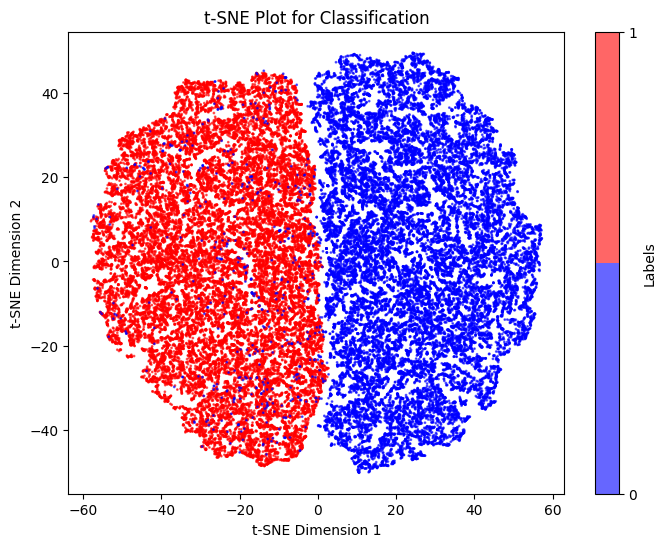

In [11]:
custom_cmap = ListedColormap(['blue', 'red'])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=custom_cmap, marker='o', s=1, alpha=0.6)

# Add a colorbar for label mapping
plt.colorbar(scatter, label='Labels', ticks=np.unique(labels))

plt.title('t-SNE Plot for Classification')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## Objective 2 - Plot the active learning accuracy 

In [47]:
#Initialize the Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators = 300, random_state = 25)

In [48]:
#active learning loop
num_iterations = 40

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_labeled, Y_labeled)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test,Y_test_pred)
    precision_array[iteration] = precision
    recall = recall_score(Y_test,Y_test_pred)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test,Y_test_pred)
    f1_array[iteration] = f1
    frac_labeled = Y_labeled.sum()/len(Y_labeled)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_labeled}")
    print(" ") #Print a blank line
    
    #Calculate uncertainty scores
    uncertainty_scores = np.max(random_forest.predict_proba(X_unlabeled),axis = 1)
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(uncertainty_scores)[:num_samples_to_label]
    
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
    
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 300, random_state = 25)
final_random_forest.fit(X_labeled, Y_labeled)


#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_test_pred)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_test_pred)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_test_pred)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.749354
Iteration : 1: Test Precision = 0.695840
Iteration : 1: Test Recall = 0.884907
Iteration : 1: Test F1 = 0.779067
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.941576
Iteration : 2: Test Precision = 0.895290
Iteration : 2: Test Recall = 0.999964
Iteration : 2: Test F1 = 0.944736
Iteration : 2: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 3: Test Accuracy = 0.988512
Iteration : 3: Test Precision = 0.985894
Iteration : 3: Test Recall = 0.991178
Iteration : 3: Test F1 = 0.988529
Iteration : 3: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 4: Test Accuracy = 0.991279
Iteration : 4: Test Precision = 0.983045
Iteration : 4: Test Recall = 0.999781
Iteration : 4: Test F1 = 0.991342
Iteration : 4: Fraction of allowed points in labeled dataset = 0.375
 
Iteration : 5: Test Accuracy = 0.983833
Iteration : 5: Test Precision = 0.996483
Iteration : 5:

Iteration : 36: Test Accuracy = 0.999599
Iteration : 36: Test Precision = 0.999199
Iteration : 36: Test Recall = 1.000000
Iteration : 36: Test F1 = 0.999599
Iteration : 36: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 37: Test Accuracy = 0.999454
Iteration : 37: Test Precision = 0.999162
Iteration : 37: Test Recall = 0.999745
Iteration : 37: Test F1 = 0.999453
Iteration : 37: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 38: Test Accuracy = 0.999545
Iteration : 38: Test Precision = 0.999235
Iteration : 38: Test Recall = 0.999854
Iteration : 38: Test F1 = 0.999544
Iteration : 38: Fraction of allowed points in labeled dataset = 0.4868421052631579
 
Iteration : 39: Test Accuracy = 0.999581
Iteration : 39: Test Precision = 0.999344
Iteration : 39: Test Recall = 0.999818
Iteration : 39: Test F1 = 0.999581
Iteration : 39: Fraction of allowed points in labeled dataset = 0.48717948717948717
 
Iteration : 40: Test Accuracy = 0.999636
Iteration : 40: Test

Text(0, 0.5, 'F1-score')

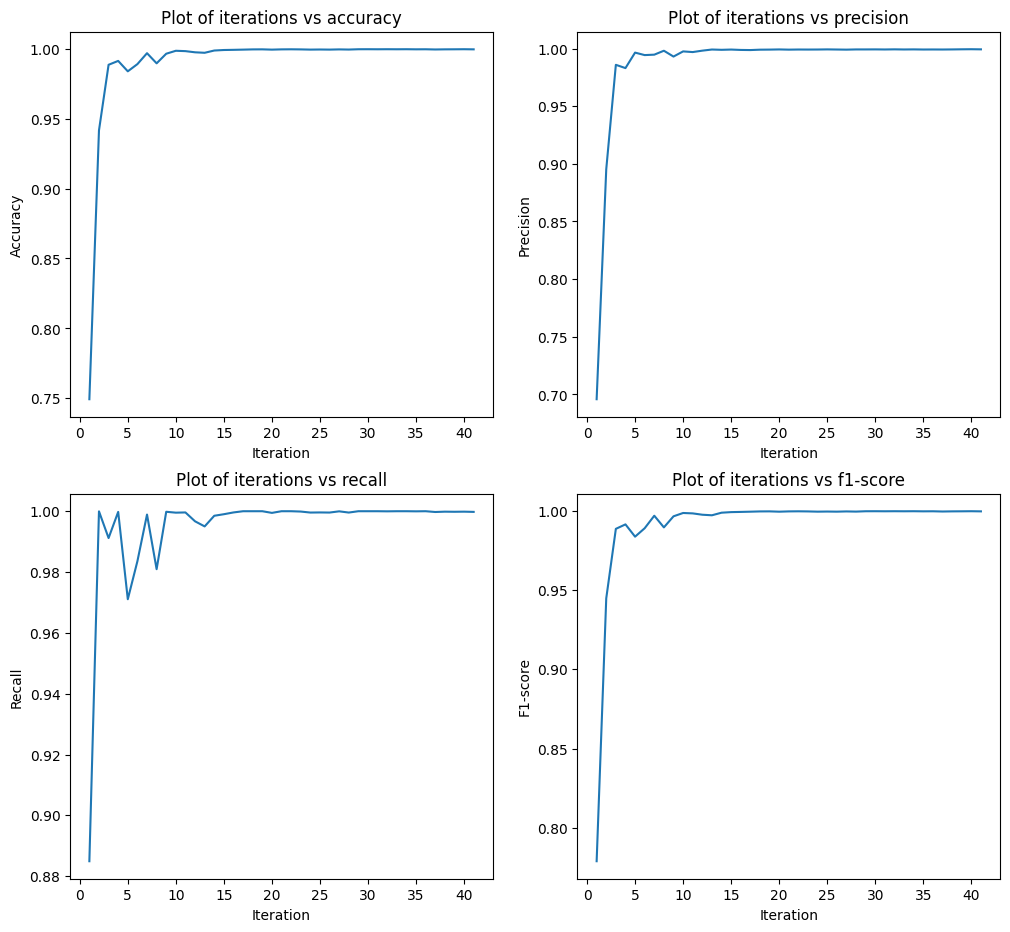

In [49]:
# Plot iteration vs accuracy

plt.figure(figsize=(12, 11))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")

In [50]:
#Plot the ROC curve

Y_final_pred_prob = final_random_forest.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, Y_final_pred_prob)

In [51]:
#Find index where the value of tpr is 1

max_tpr = np.where(tpr==1)[0][0]
max_threshold = thresholds[max_tpr]

print(f"Optimum Threshold Value : {max_threshold}")

Optimum Threshold Value : 0.48


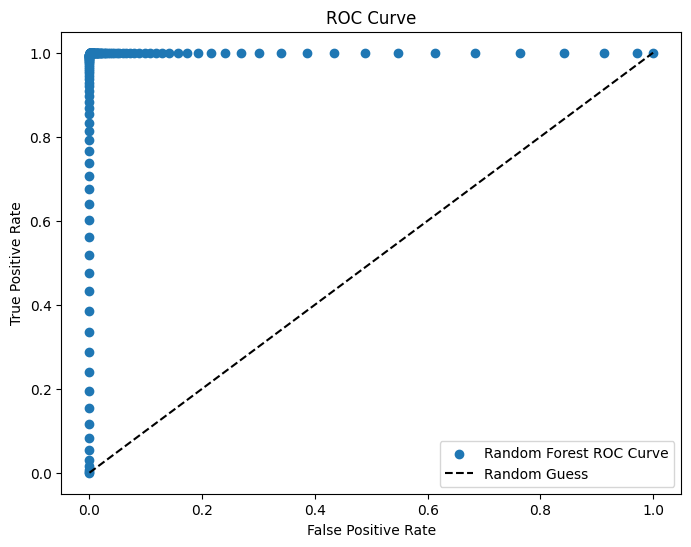

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(fpr, tpr, label='Random Forest ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Definitions

Precision :- Precision measures the ratio of correctly predicted positive observations(true positives) to the total predicted positive observations(true positives + false positives). This is to check classifier's ability to avoid false positives.

Recall :- Recall measures the ratio of correctly predicted positive observations(true positives) to the total actual positive observations(true positives + false negatives). This is to check how well the classifier identifies all positive instances.

F1-Score :- F1-score is the harmonic mean of precision and Recall. A high F1-Score indicated a good balance between precision and recall.

Specificity :- This measures the ratio of correctly predicted negative observations(true negatives) to the total actual negative observations(true negatives + false positives). 

## Objective 3 - Visualize Classfication Boundary 

In [11]:
#Initialize the Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 25)

In [12]:
#Function that predicts classification boundary

def TSNE_boundary(X_labeled,Y_labeled):
    #Create a TSNE Boundary Prediction Plot
    features = X_labeled.values
    labels = Y_labeled.values
    
    tsne = TSNE(n_components=2, perplexity=1, learning_rate=100)
    tsne_results = tsne.fit_transform(features)
    
    #Code to train the Decision Tree Classifier in the TSNE space
    random_tsne = RandomForestClassifier(n_estimators = 100, random_state = 25)
    random_tsne.fit(tsne_results, labels)
    
    # Create a grid of points in the t-SNE space
    x_min, x_max = tsne_results[:, 0].min() - 1, tsne_results[:, 0].max() + 1
    y_min, y_max = tsne_results[:, 1].min() - 1, tsne_results[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
    
    # Use the Random Forest Classifier to predict labels for the grid points
    Z = random_tsne.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the t-SNE scatter points
    plt.figure(figsize=(8, 6))
    custom_cmap = ListedColormap(['blue', 'red'])
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=custom_cmap, marker='o', s=1, alpha=1)

    # Overlay a decision boundary as a line
    plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)

    # Add a colorbar for label mapping
    plt.colorbar(scatter, label='Labels', ticks=np.unique(labels))

    plt.title('t-SNE Plot with Decision Boundaries')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

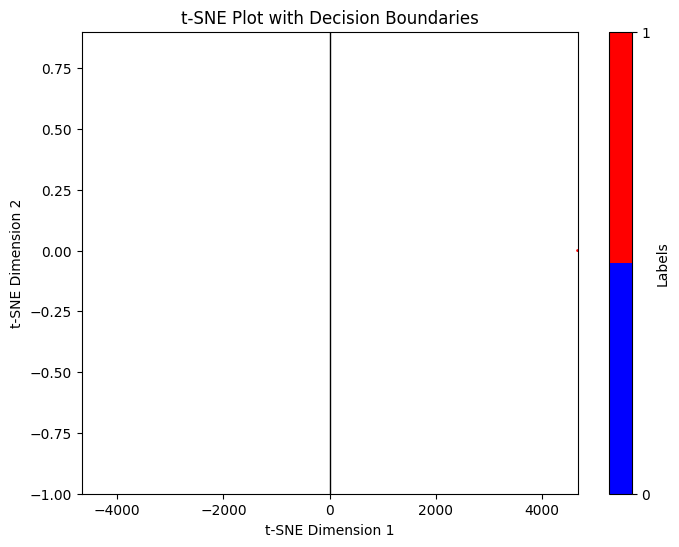

Iteration : 1: Test Accuracy = 0.736482


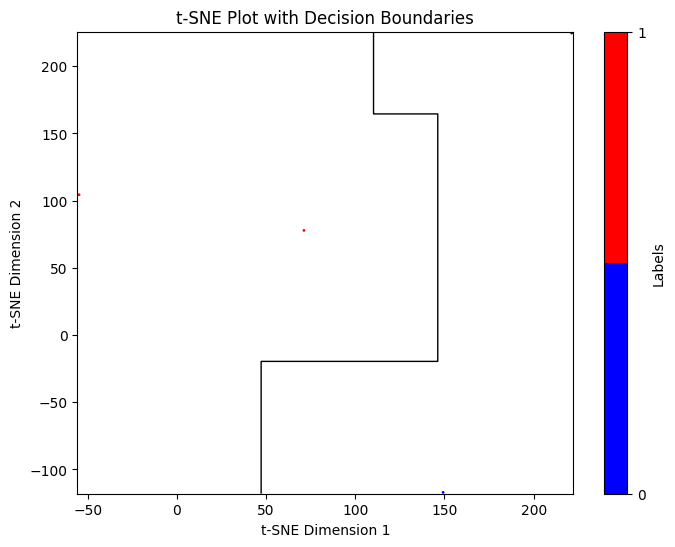

Iteration : 2: Test Accuracy = 0.885919


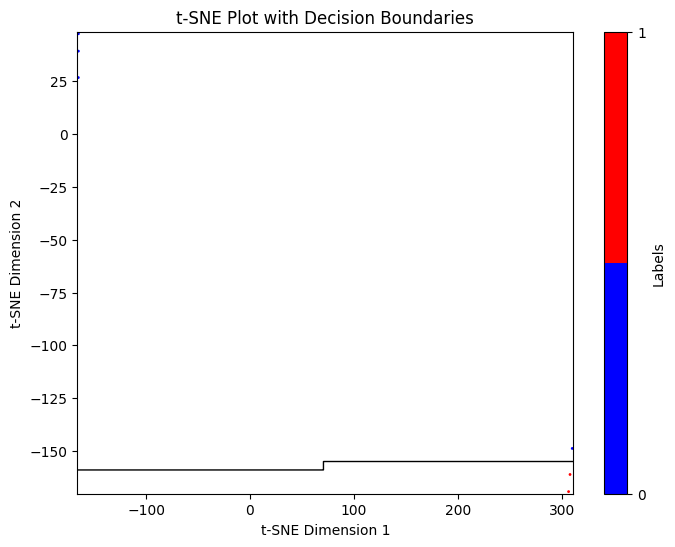

Iteration : 3: Test Accuracy = 0.970651


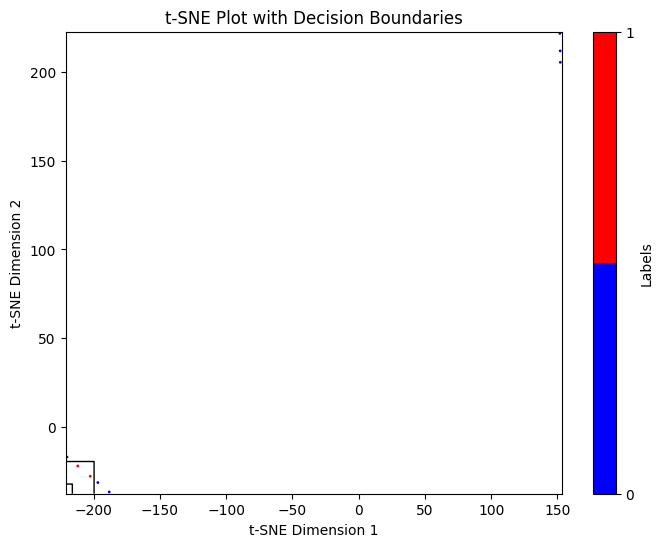

Iteration : 4: Test Accuracy = 0.993373


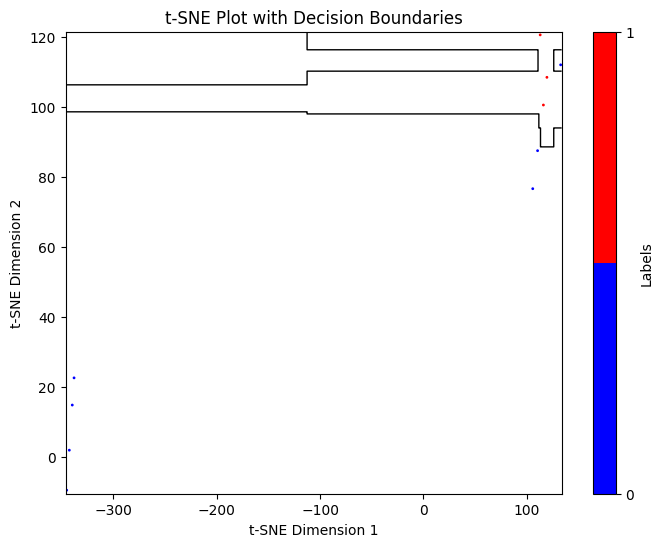

Iteration : 5: Test Accuracy = 0.980501


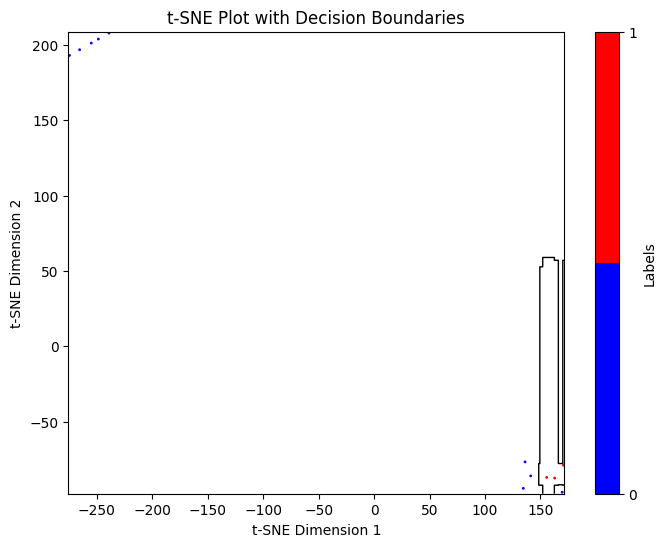

Iteration : 6: Test Accuracy = 0.996723


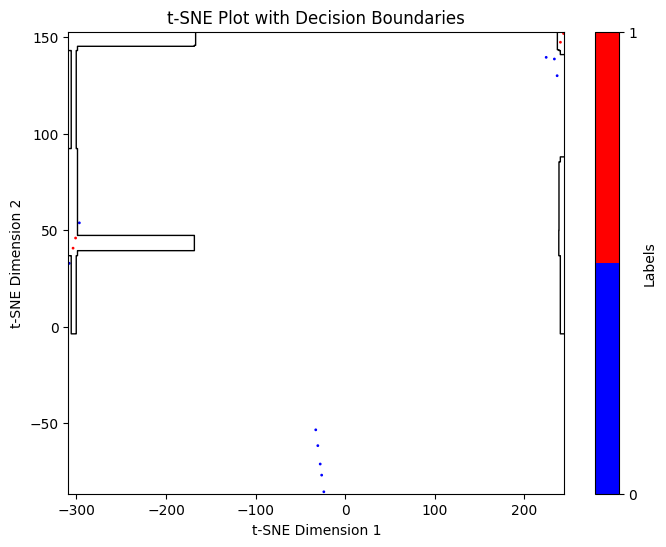

Iteration : 7: Test Accuracy = 0.997761


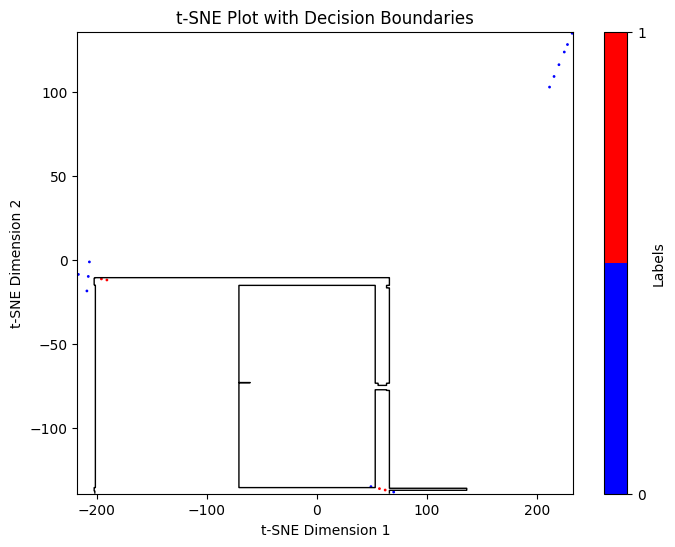

Iteration : 8: Test Accuracy = 0.997870


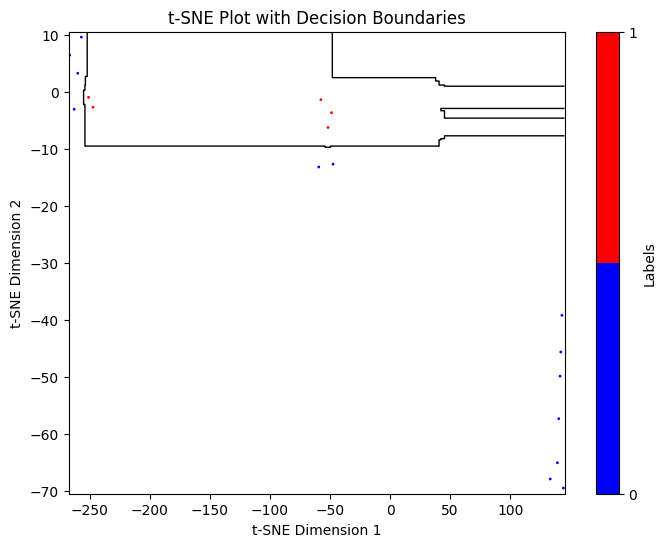

Iteration : 9: Test Accuracy = 0.996213


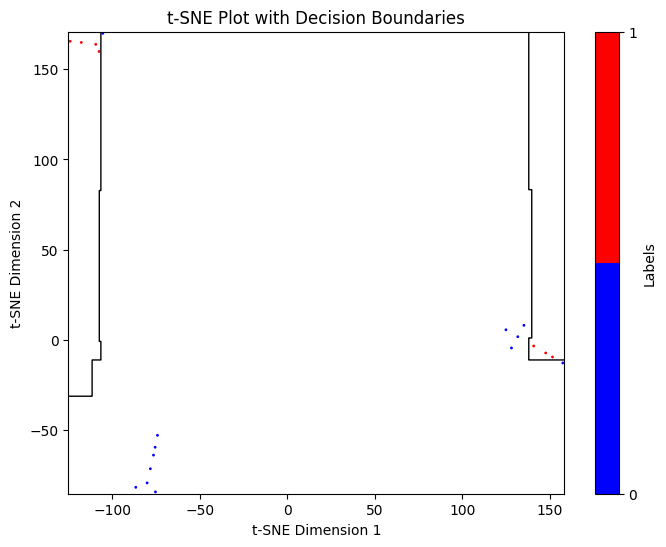

Iteration : 10: Test Accuracy = 0.998689


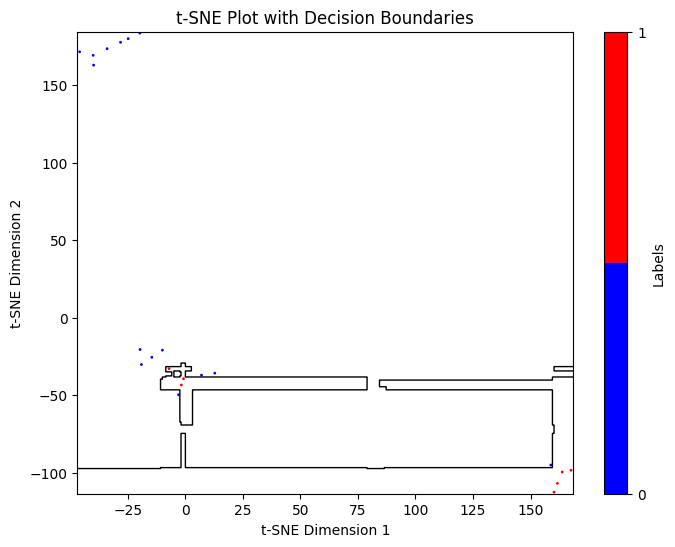

Iteration : 11: Test Accuracy = 0.997979


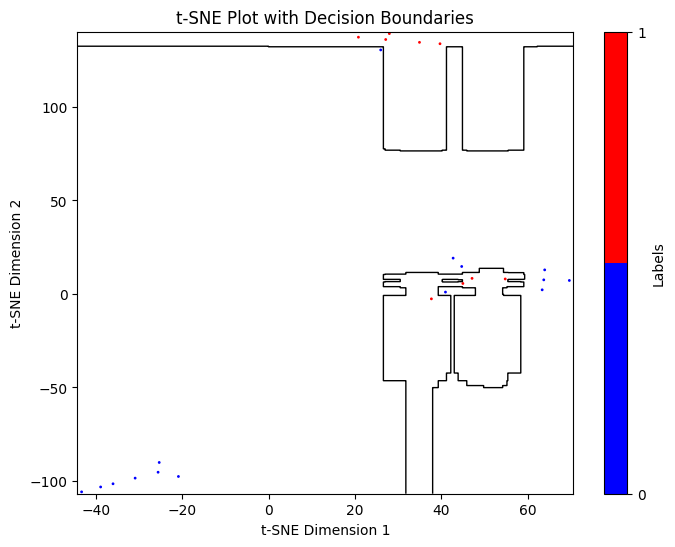

Iteration : 12: Test Accuracy = 0.998744


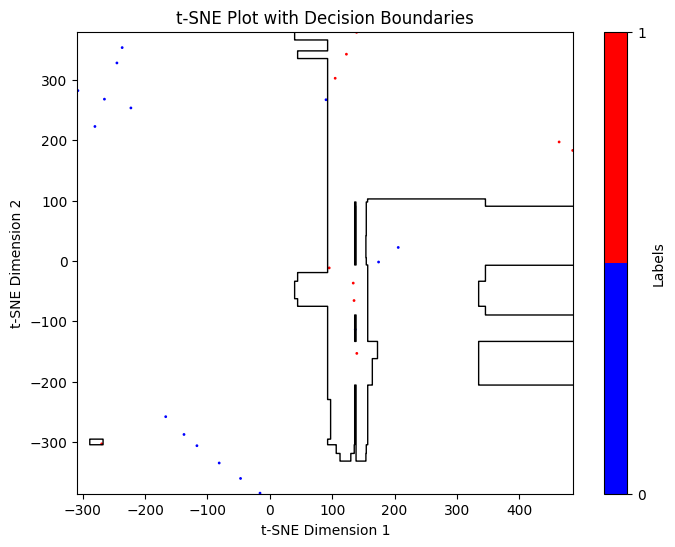

Iteration : 13: Test Accuracy = 0.998598


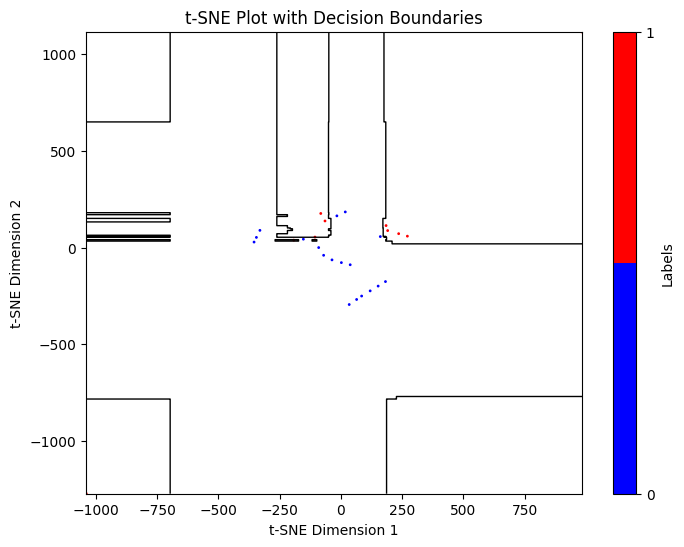

Iteration : 14: Test Accuracy = 0.999454


KeyboardInterrupt: 

In [13]:
#active learning loop
num_iterations = 18

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    
    #Call the TSNE Boundary function which predicts classification boundary
    TSNE_boundary(X_labeled,Y_labeled)
    
    #Train the model
    random_forest.fit(X_labeled, Y_labeled)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    
    #Calculate uncertainty scores
    uncertainty_scores = np.max(random_forest.predict_proba(X_unlabeled),axis = 1)
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(uncertainty_scores)[:num_samples_to_label]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
        
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 100, random_state = 25)
final_random_forest.fit(X_labeled, Y_labeled)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy

TSNE_boundary(X_labeled,Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")

## Objective 4 - Corner Plot

In [2]:
#reading the file containing allowed points
data_pas = pd.read_csv('Alignment-1-New.csv')

In [4]:
#check for any empty cell in database
data_pas.isna().sum()

mH1          0
mH2          0
mH3          0
mA1          0
mA2          0
mC1          0
mC2          0
TanBeta1     0
TanBeta2     0
TanAlpha4    0
TanGamma1    0
TanGamma2    0
TanAlpha1    0
TanAlpha2    0
dtype: int64

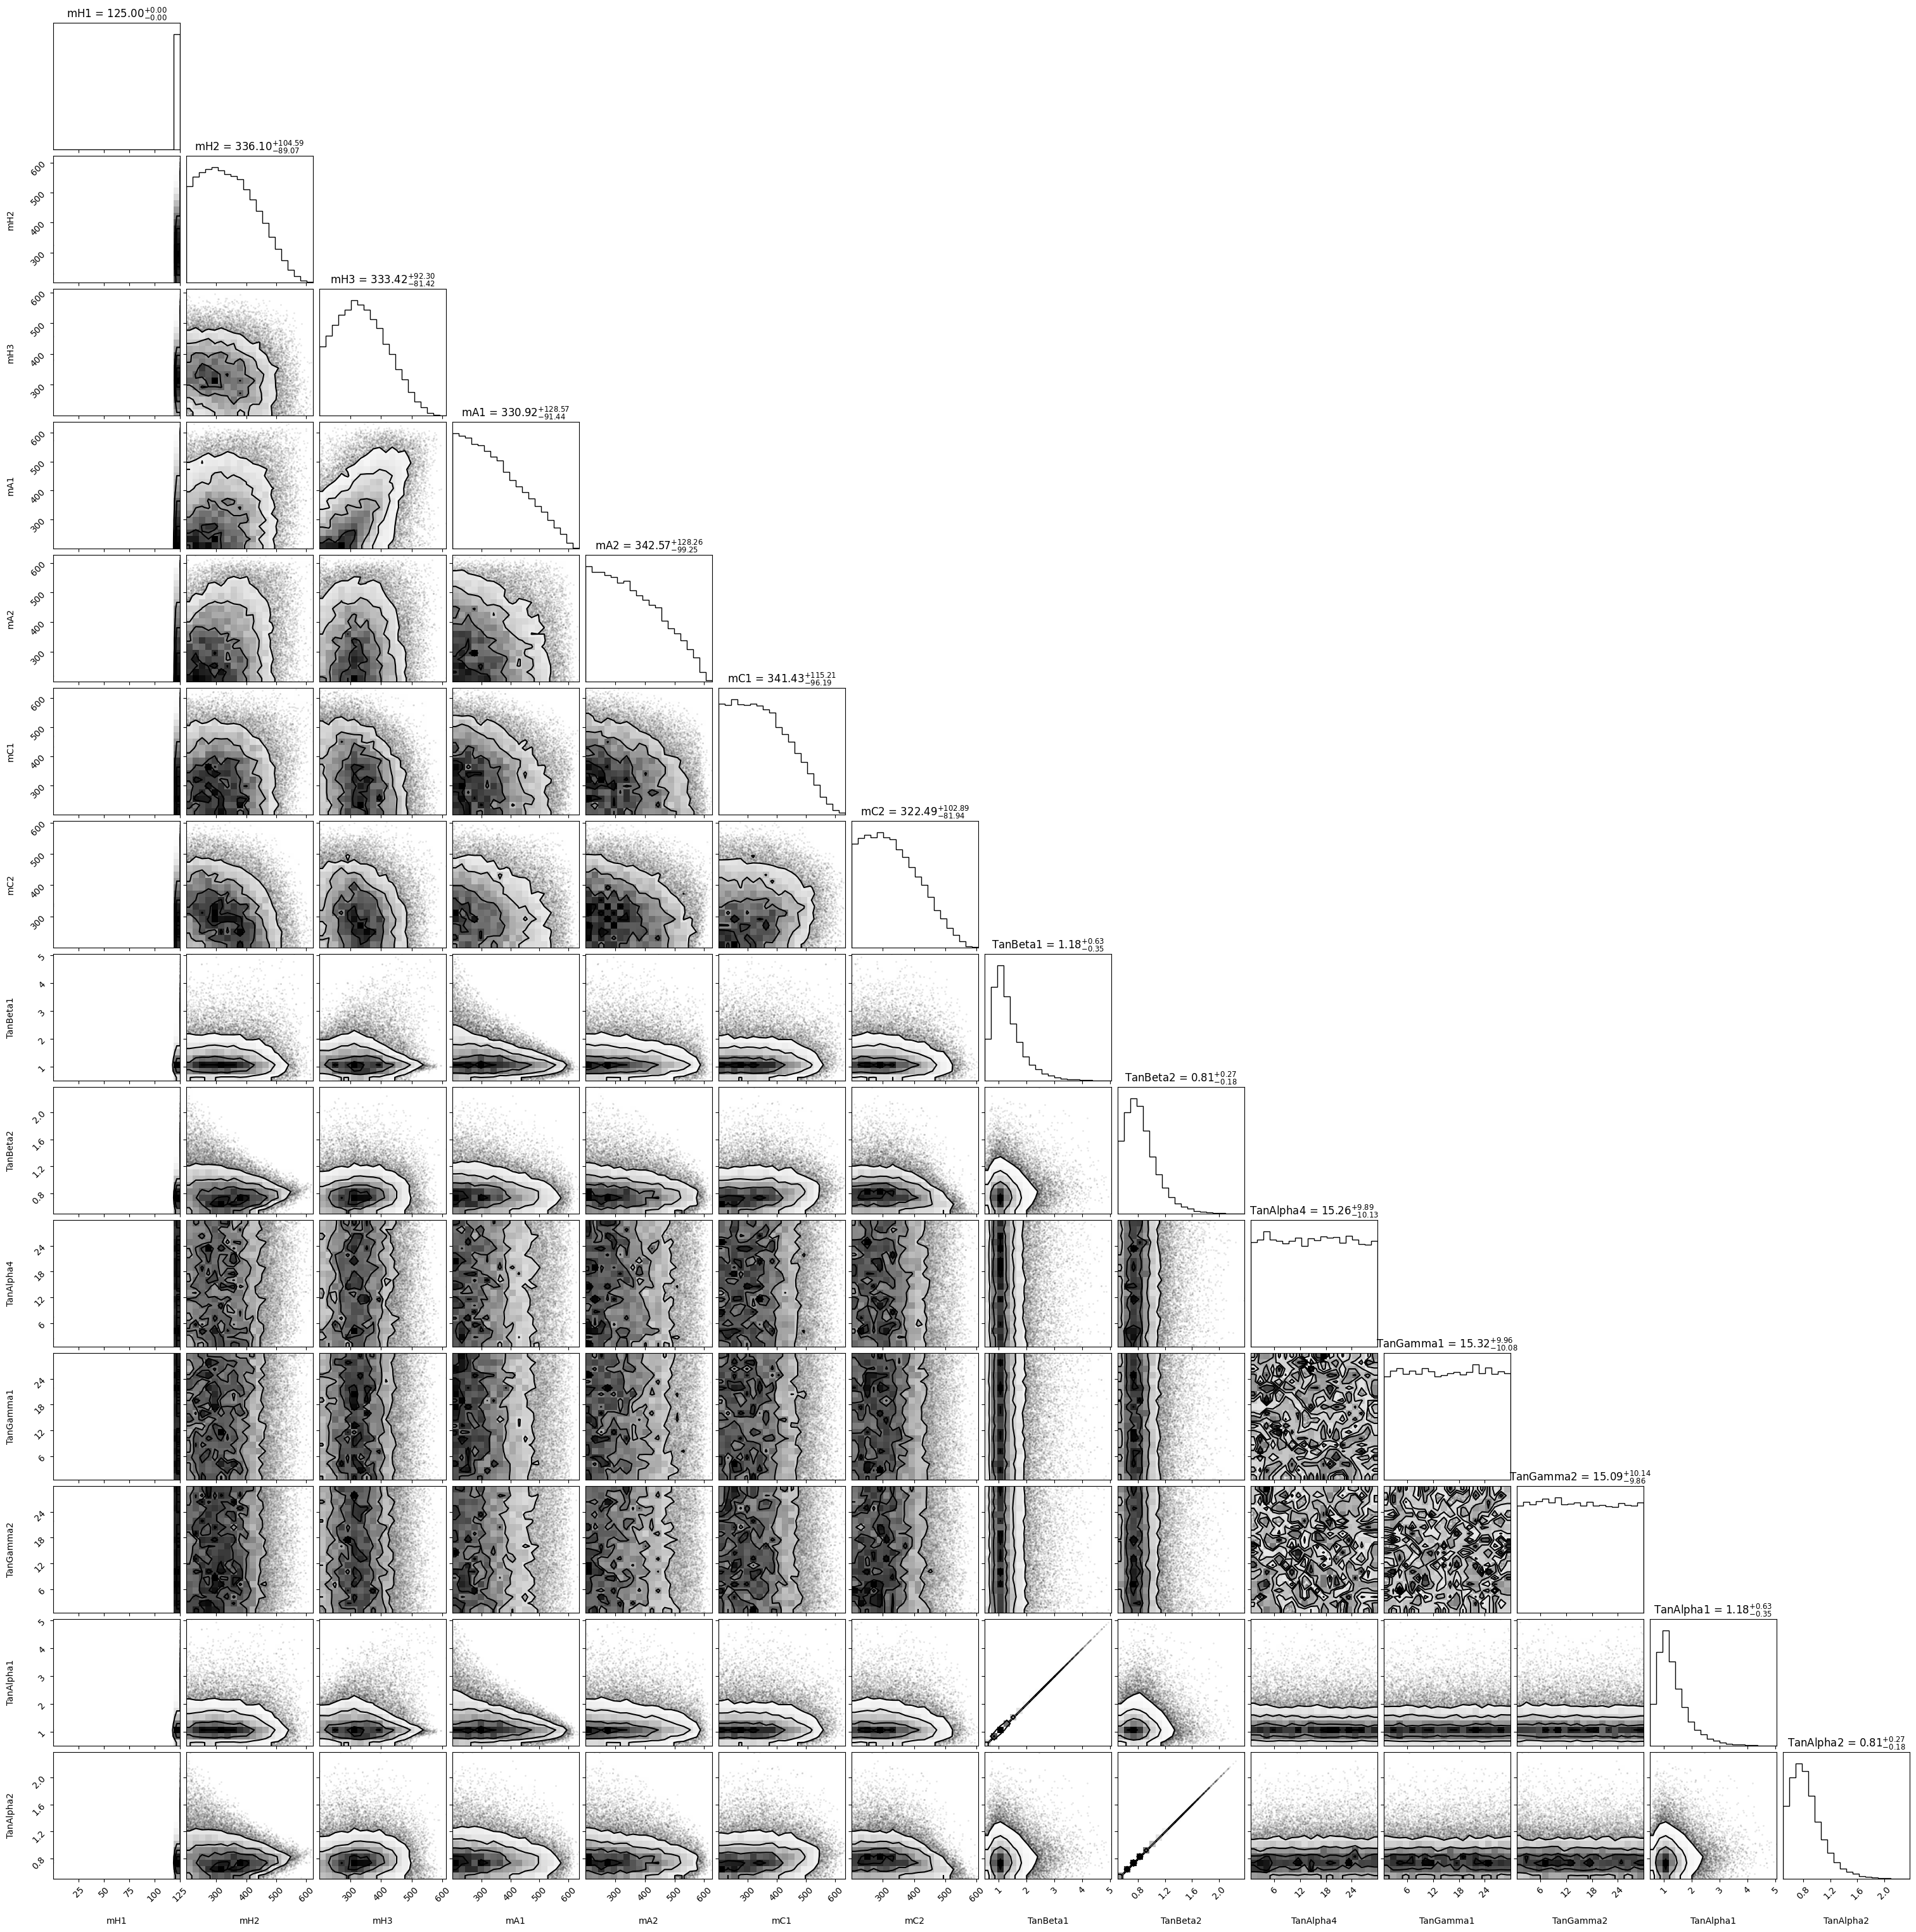

In [5]:
#corner plot
figure = corner.corner(data_pas, labels=data_pas.columns, show_titles=True)

plt.show()

## Objective 4 - Generate new points and label them within the active learning loop

In [7]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.99992, random_state = 12)

frac_allowed = Y_train.sum()/len(Y_train)

In [8]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of train datapoints: {len(X_train)}")
print(f"Number of test datapoints: {len(X_test)}")
print(f"Fraction of allowed points in labeled dataset: {frac_allowed}")

Total Number of datapoints: 59832
Number of train datapoints: 4
Number of test datapoints: 59828
Fraction of allowed points in labeled dataset: 0.5


In [9]:
#Initialize the Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators = 250, random_state = 12)

In [10]:
#defining a function that generates and labels live most uncertain datapoints

import Functions as func

def live_generation(gen_batch_size,seed,unc_batch_size):
    
    #generate new datapoints :- syntax (generate(batch,seed))
    points = func.generate(gen_batch_size,seed)
    
    #Calculate uncertainty scores
    uncertainty_scores = np.max(random_forest.predict_proba(points),axis = 1)
    
    #Select the indices of the most uncertain samples
    num_samples_to_label = unc_batch_size
    selected_indices = np.argsort(uncertainty_scores)[:num_samples_to_label]
    
    #convert the pandas dataframe to array/list
    points_array = points.values
    
    #create a numpy array of the selected most uncertain samples from the indices
    data_tolabel = np.array([points_array[i] for i in selected_indices])
    
    #check the constraints on the the generated dataset
    points_allowed, points_disallowed = func.constraints_check(data_tolabel)
    
    #create a pandas dataframe of the check dataset
    column_names = ['mH1','mH2','mH3','mA1','mA2','mC1','mC2','TanBeta1','TanBeta2','TanAlpha4','TanGamma1','TanGamma2','TanAlpha1','TanAlpha2']

    data_disallowed = pd.DataFrame(points_disallowed, columns=column_names)
    data_allowed = pd.DataFrame(points_allowed, columns=column_names)
    
    #label the dataset
    data_allowed['Output'] = 1
    data_disallowed['Output'] = 0
    
    #merge the dataset
    labeled = pd.concat([data_allowed,data_disallowed], ignore_index=True)
    
    #extract the X_labeled and Y_labeled
    X_labeled = labeled.drop('Output', axis = 1)
    Y_labeled = labeled['Output']
    
    return X_labeled, Y_labeled

## Generating 20 M Live Points 

#### Failed due to low fraction of allowed points

In [21]:
#active learning loop
num_iterations = 20

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_train, Y_train)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test,Y_test_pred)
    precision_array[iteration] = precision
    recall = recall_score(Y_test,Y_test_pred)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test,Y_test_pred)
    f1_array[iteration] = f1
    frac_allowed = Y_train.sum()/len(Y_train)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_allowed}")
    print(" ") #Print a blank line
    
    #generate and label new data points :- syntax (live_generation(gen_batch_size,seed,unc_batch_size))
    seed = 1000
    X_new, Y_new = live_generation(20000000,seed,2)
   
    #move the selected samples from unlabeled to labeled data
    X_train = pd.concat([X_train, X_new])
    Y_train = pd.concat([Y_train, pd.Series(Y_new)])
    
    #increase the count of seed
    seed = seed + 1
       
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12)
final_random_forest.fit(X_train, Y_train)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_test_pred)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_test_pred)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_test_pred)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.752908
Iteration : 1: Test Precision = 0.668639
Iteration : 1: Test Recall = 1.000000
Iteration : 1: Test F1 = 0.801419
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.952079
Iteration : 2: Test Precision = 0.912417
Iteration : 2: Test Recall = 0.999866
Iteration : 2: Test F1 = 0.954142
Iteration : 2: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 3: Test Accuracy = 0.993933
Iteration : 3: Test Precision = 0.995727
Iteration : 3: Test Recall = 0.992089
Iteration : 3: Test F1 = 0.993904
Iteration : 3: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 4: Test Accuracy = 0.931587
Iteration : 4: Test Precision = 0.996949
Iteration : 4: Test Recall = 0.865437
Iteration : 4: Test F1 = 0.926550
Iteration : 4: Fraction of allowed points in labeled dataset = 0.2
 
Iteration : 5: Test Accuracy = 0.923882
Iteration : 5: Test Precision = 0.996855
Iteration : 5: 

KeyboardInterrupt: 

## Generating 40 M Live points

#### Failed due to low fraction of allowed points

In [11]:
#active learning loop
num_iterations = 20

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_train, Y_train)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test,Y_test_pred)
    precision_array[iteration] = precision
    recall = recall_score(Y_test,Y_test_pred)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test,Y_test_pred)
    f1_array[iteration] = f1
    frac_allowed = Y_train.sum()/len(Y_train)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_allowed}")
    print(" ") #Print a blank line
    
    #generate and label new data points :- syntax (live_generation(gen_batch_size,seed,unc_batch_size))
    seed = 1000
    X_new, Y_new = live_generation(40000000,seed,2)
   
    #move the selected samples from unlabeled to labeled data
    X_train = pd.concat([X_train, X_new])
    Y_train = pd.concat([Y_train, pd.Series(Y_new)])
    
    #increase the count of seed
    seed = seed + 1
       
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12)
final_random_forest.fit(X_train, Y_train)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_test_pred)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_test_pred)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_test_pred)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.752908
Iteration : 1: Test Precision = 0.668639
Iteration : 1: Test Recall = 1.000000
Iteration : 1: Test F1 = 0.801419
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.969747
Iteration : 2: Test Precision = 0.942850
Iteration : 2: Test Recall = 0.999933
Iteration : 2: Test F1 = 0.970553
Iteration : 2: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 3: Test Accuracy = 0.992010
Iteration : 3: Test Precision = 0.984293
Iteration : 3: Test Recall = 0.999933
Iteration : 3: Test F1 = 0.992051
Iteration : 3: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 4: Test Accuracy = 0.971368
Iteration : 4: Test Precision = 0.993090
Iteration : 4: Test Recall = 0.949179
Iteration : 4: Test F1 = 0.970638
Iteration : 4: Fraction of allowed points in labeled dataset = 0.2
 
Iteration : 5: Test Accuracy = 0.901401
Iteration : 5: Test Precision = 0.999416
Iteration : 5: 

KeyboardInterrupt: 

## Generating 60 M Live points

#### Failed due to low fraction of allowed points

In [11]:
#active learning loop
num_iterations = 20

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_train, Y_train)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test,Y_test_pred)
    precision_array[iteration] = precision
    recall = recall_score(Y_test,Y_test_pred)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test,Y_test_pred)
    f1_array[iteration] = f1
    frac_allowed = Y_train.sum()/len(Y_train)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_allowed}")
    print(" ") #Print a blank line
    
    #generate and label new data points :- syntax (live_generation(gen_batch_size,seed,unc_batch_size))
    seed = 1000
    X_new, Y_new = live_generation(60000000,seed,2)
   
    #move the selected samples from unlabeled to labeled data
    X_train = pd.concat([X_train, X_new])
    Y_train = pd.concat([Y_train, pd.Series(Y_new)])
    
    #increase the count of seed
    seed = seed + 1
       
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 150, random_state = 12)
final_random_forest.fit(X_train, Y_train)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_test_pred)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_test_pred)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_test_pred)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.736896
Iteration : 1: Test Precision = 0.654583
Iteration : 1: Test Recall = 1.000000
Iteration : 1: Test F1 = 0.791236
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.965601
Iteration : 2: Test Precision = 0.935462
Iteration : 2: Test Recall = 1.000000
Iteration : 2: Test F1 = 0.966655
Iteration : 2: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 3: Test Accuracy = 0.976800
Iteration : 3: Test Precision = 0.996717
Iteration : 3: Test Recall = 0.956621
Iteration : 3: Test F1 = 0.976257
Iteration : 3: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 4: Test Accuracy = 0.869008
Iteration : 4: Test Precision = 0.999047
Iteration : 4: Test Recall = 0.737982
Iteration : 4: Test F1 = 0.848896
Iteration : 4: Fraction of allowed points in labeled dataset = 0.2
 


KeyboardInterrupt: 

## Generating 50 M Live points and increased estimators by 100

#### Failed due to low fraction of allowed points

In [11]:
#active learning loop
num_iterations = 20

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_train, Y_train)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test,Y_test_pred)
    precision_array[iteration] = precision
    recall = recall_score(Y_test,Y_test_pred)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test,Y_test_pred)
    f1_array[iteration] = f1
    frac_allowed = Y_train.sum()/len(Y_train)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_allowed}")
    print(" ") #Print a blank line
    
    #generate and label new data points :- syntax (live_generation(gen_batch_size,seed,unc_batch_size))
    seed = 1000
    X_new, Y_new = live_generation(50000000,seed,2)
   
    #move the selected samples from unlabeled to labeled data
    X_train = pd.concat([X_train, X_new])
    Y_train = pd.concat([Y_train, pd.Series(Y_new)])
    
    #increase the count of seed
    seed = seed + 1
       
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 250, random_state = 12)
final_random_forest.fit(X_train, Y_train)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_test_pred)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_test_pred)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_test_pred)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.741208
Iteration : 1: Test Precision = 0.658310
Iteration : 1: Test Recall = 1.000000
Iteration : 1: Test F1 = 0.793953
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.961490
Iteration : 2: Test Precision = 0.928300
Iteration : 2: Test Recall = 1.000000
Iteration : 2: Test F1 = 0.962817
Iteration : 2: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 3: Test Accuracy = 0.990941
Iteration : 3: Test Precision = 0.986738
Iteration : 3: Test Recall = 0.995206
Iteration : 3: Test F1 = 0.990954
Iteration : 3: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 4: Test Accuracy = 0.926372
Iteration : 4: Test Precision = 0.994361
Iteration : 4: Test Recall = 0.857191
Iteration : 4: Test F1 = 0.920695
Iteration : 4: Fraction of allowed points in labeled dataset = 0.2
 


KeyboardInterrupt: 

## Plot below is not Updated

Text(0, 0.5, 'Accuracy')

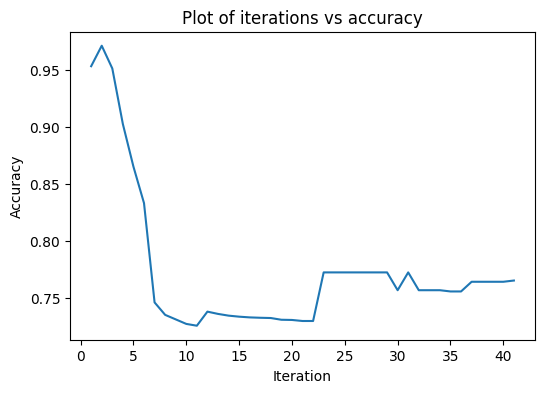

In [12]:
# Plot iteration vs accuracy

plt.figure(figsize=(12, 11))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")